In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
from torch.utils.data import DataLoader
import os
from datetime import datetime
import math
import open3d as o3d
from utilities import convert_to_shoulder_coord
import time
import pandas as pd
from csv_writer import fusion_csv_columns_name
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import threading
import queue

from angle_calculation_v2 import (calculate_angle_j1, 
    calculate_angle_j2)
from send_data_to_robot import send_udp_message

%matplotlib notebook

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))
val_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "val")))

#fake_train_paths = glob.glob(os.path.join(DATA_DIR, "fake_data", "train", "fake_*.csv"))

#if len(fake_train_paths) > 0:
    #train_paths.extend(fake_train_paths)

body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200
val_body_distance_thres = 450
val_leftarm_distance_thres = 450
val_lefthand_distance_thres = 150

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = HandArmLandmarksDataset_ANN(val_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)  

In [3]:
train_dataset._outputs.shape

(3867, 144)

In [4]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [5]:
target_output = train_dataset._outputs  #  shape: (N, 144)
sample = target_output[0]  # shape: (144)
sample = sample.reshape(3, 48)  # shape: (3, 48)
sample = sample.T  # shape: (48, 3)
sample = sample[:26]  # shape: (26, 3)

In [6]:
body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
lines = body_lines.copy()
lines.extend(lefthand_lines)

In [7]:
pts, original_xyz = convert_to_shoulder_coord(sample, arm_hand_fused_names)

In [22]:
colors = [[0, 0, 0] for i in range(len(lines))]

# Draw original xyz
x_unit, y_unit, z_unit = original_xyz[:, 0], original_xyz[:, 1], original_xyz[:, 2]
pts = np.concatenate([pts, [x_unit * 40, y_unit * 40, z_unit * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Draw shoulder xyz
angle_j1, shoulder_coords_in_world = calculate_angle_j1(pts, arm_hand_fused_names)
x_shoulder, y_shoulder, z_shoulder = shoulder_coords_in_world[:, 0],  shoulder_coords_in_world[:, 1], shoulder_coords_in_world[:, 2]
pts = np.concatenate([pts, [x_shoulder * 40, y_shoulder * 40, z_shoulder * 40]], axis=0)
last_index = pts.shape[0] - 1
lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(pts),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd, line_set])

In [8]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))

In [9]:
#train_paths = [train_paths[0]]
train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)

ground_truth_data = train_dataset._outputs

In [10]:
TARGET_ANGLES_QUEUE = queue.Queue()
TARGET_ANGLES_QUEUE.put(np.zeros(6))

In [12]:
fps = 12
time_sleep = 1 / 12

target_output = ground_truth_data  # shape: (N, 144)
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
#vis.add_geometry(bounding_box)

j1_angles = []
j2_angles = []

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)
    colors = [[0, 0, 0] for i in range(len(lines))]

    points, original_xyz = convert_to_shoulder_coord(output,
        arm_hand_fused_names)

    # Draw original xyz
    x_unit, y_unit, z_unit = original_xyz[:, 0], original_xyz[:, 1], original_xyz[:, 2]
    points = np.concatenate([points, [x_unit * 40, y_unit * 40, z_unit * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

    # Draw j1 xyz
    angle_j1, j1_coords_in_world = calculate_angle_j1(points, arm_hand_fused_names)    
    x_j1, y_j1, z_j1 = j1_coords_in_world[:, 0], j1_coords_in_world[:, 1], j1_coords_in_world[:, 2]
    points = np.concatenate([points, [x_j1 * 40, y_j1 * 40, z_j1 * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    j1_angles.append(angle_j1)
    
    # Draw j2 xyz
    angle_j2, j2_coords_in_w, j2_coords_in_j1 = calculate_angle_j2(points, arm_hand_fused_names, j1_coords_in_world, angle_j1)
    x_j2, y_j2, z_j2 = j2_coords_in_w[:, 0], j2_coords_in_w[:, 1], j2_coords_in_w[:, 2]
    points = np.concatenate([points, [x_j2 * 40, y_j2 * 40, z_j2 * 40]], axis=0)
    last_index = points.shape[0] - 1
    lines.extend([[0, last_index - 2], [0, last_index - 1], [0, last_index]])
    colors.extend([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    j2_angles.append(angle_j2)
 
    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    pcd.points = o3d.utility.Vector3dVector(points)
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    #vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
    
    # Send UDP message
    arm_angles = np.array([angle_j1, angle_j2, 0, 0, 0, 0])
    TARGET_ANGLES_QUEUE.put(arm_angles)
    if TARGET_ANGLES_QUEUE.qsize() > 1:
        TARGET_ANGLES_QUEUE.get()
        
    time.sleep(time_sleep)

vis.destroy_window()


<IPython.core.display.Javascript object>


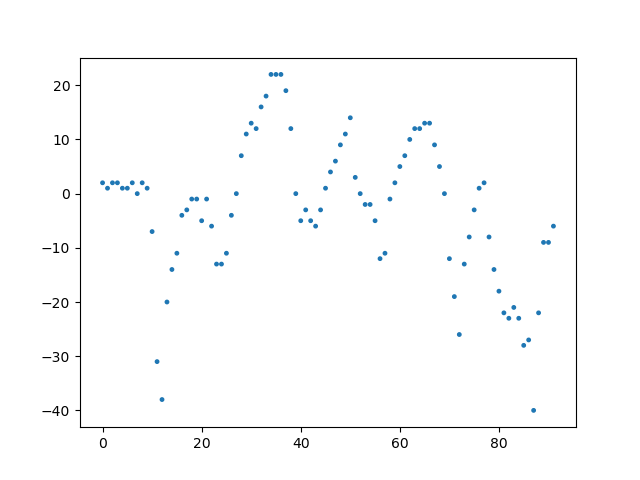

In [22]:
_ = plt.figure()
plt.scatter(range(0, len(j1_angles)), j1_angles, sizes=[6] * len(j1_angles))
plt.show()

<IPython.core.display.Javascript object>


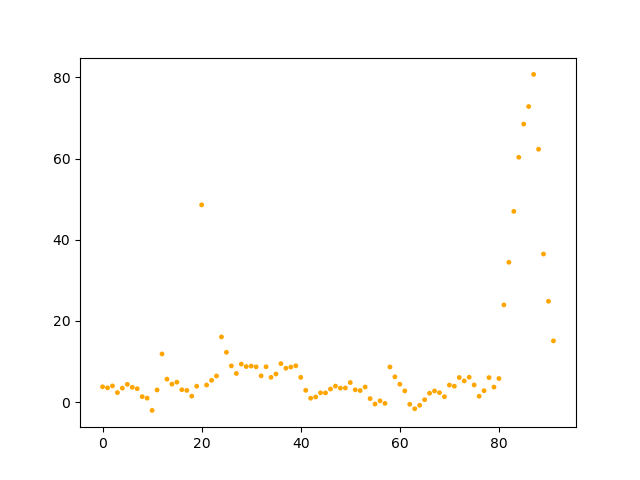

In [25]:
_ = plt.figure()
plt.scatter(range(0, len(j2_angles)), j2_angles, sizes=[6] * len(j2_angles), color='orange')
plt.show()

In [11]:
send_data_thread = threading.Thread(target=send_udp_message, 
                                    args=(TARGET_ANGLES_QUEUE, True, 0.6), daemon=True)
send_data_thread.start()

target:  [0. 0. 0. 0. 0. 0.]
UDP message:  [0. 0. 0. 0. 0. 0.]
target:  [13.          9.35210251  0.          0.          0.          0.        ]
UDP message:  [13.          9.35210251  0.          0.          0.          0.        ]
target:  [14.          6.82971406  0.          0.          0.          0.        ]
UDP message:  [14.          6.82971406  0.          0.          0.          0.        ]
target:  [14.         7.8709136  0.         0.         0.         0.       ]
UDP message:  [14.         7.8709136  0.         0.         0.         0.       ]
target:  [3.         9.53716222 0.         0.         0.         0.        ]
UDP message:  [3.         9.53716222 0.         0.         0.         0.        ]
target:  [2.         8.81854485 0.         0.         0.         0.        ]
UDP message:  [2.         8.81854485 0.         0.         0.         0.        ]
target:  [10.         12.97258882  0.          0.          0.          0.        ]
UDP message:  [10.         12.97258

target:  [-1.          2.33202514  0.          0.          0.          0.        ]
UDP message:  [-1.          2.33202514  0.          0.          0.          0.        ]
target:  [0.        0.5672453 0.        0.        0.        0.       ]
UDP message:  [0.        0.5672453 0.        0.        0.        0.       ]
target:  [-1.          8.51883269  0.          0.          0.          0.        ]
UDP message:  [-1.          8.51883269  0.          0.          0.          0.        ]
target:  [1.         1.99627675 0.         0.         0.         0.        ]
UDP message:  [1.         1.99627675 0.         0.         0.         0.        ]
target:  [1.         2.84520885 0.         0.         0.         0.        ]
UDP message:  [1.         2.84520885 0.         0.         0.         0.        ]
target:  [0.         2.41307392 0.         0.         0.         0.        ]
UDP message:  [0.         2.41307392 0.         0.         0.         0.        ]
target:  [0.         2.90807037 0.

target:  [1.         7.41400858 0.         0.         0.         0.        ]
UDP message:  [1.         7.41400858 0.         0.         0.         0.        ]
target:  [0.         7.79486338 0.         0.         0.         0.        ]
UDP message:  [0.         7.79486338 0.         0.         0.         0.        ]
target:  [0.         6.41923869 0.         0.         0.         0.        ]
UDP message:  [0.         6.41923869 0.         0.         0.         0.        ]
target:  [0.         5.83614324 0.         0.         0.         0.        ]
UDP message:  [0.         5.83614324 0.         0.         0.         0.        ]
target:  [0.         6.22912248 0.         0.         0.         0.        ]
UDP message:  [0.         6.22912248 0.         0.         0.         0.        ]
target:  [0.         6.19946885 0.         0.         0.         0.        ]
UDP message:  [0.         6.19946885 0.         0.         0.         0.        ]
target:  [0.         6.56168786 0.         0. 

target:  [ 1.         11.37525386  0.          0.          0.          0.        ]
UDP message:  [ 1.         11.37525386  0.          0.          0.          0.        ]
target:  [ 0.         13.09609207  0.          0.          0.          0.        ]
UDP message:  [ 0.         13.09609207  0.          0.          0.          0.        ]
target:  [-2.         16.02960874  0.          0.          0.          0.        ]
UDP message:  [-2.         16.02960874  0.          0.          0.          0.        ]
target:  [-2.         10.67040845  0.          0.          0.          0.        ]
UDP message:  [-2.         10.67040845  0.          0.          0.          0.        ]
target:  [ 0.         17.02846236  0.          0.          0.          0.        ]
UDP message:  [ 0.         17.02846236  0.          0.          0.          0.        ]
target:  [ 1.         15.90344093  0.          0.          0.          0.        ]
UDP message:  [ 1.         15.90344093  0.          0.        

target:  [0.         8.79021596 0.         0.         0.         0.        ]
UDP message:  [0.         8.79021596 0.         0.         0.         0.        ]
target:  [ 1.         17.24889709  0.          0.          0.          0.        ]
UDP message:  [ 1.         17.24889709  0.          0.          0.          0.        ]
target:  [0.         5.95459153 0.         0.         0.         0.        ]
UDP message:  [0.         5.95459153 0.         0.         0.         0.        ]
target:  [0.         3.28195973 0.         0.         0.         0.        ]
UDP message:  [0.         3.28195973 0.         0.         0.         0.        ]
target:  [0.         2.42776613 0.         0.         0.         0.        ]
UDP message:  [0.         2.42776613 0.         0.         0.         0.        ]
target:  [0.         1.00200547 0.         0.         0.         0.        ]
UDP message:  [0.         1.00200547 0.         0.         0.         0.        ]
target:  [0.         1.89767155 0.

target:  [1.         5.34216563 0.         0.         0.         0.        ]
UDP message:  [1.         5.34216563 0.         0.         0.         0.        ]
target:  [0.         5.65960461 0.         0.         0.         0.        ]
UDP message:  [0.         5.65960461 0.         0.         0.         0.        ]
target:  [0.         4.96633626 0.         0.         0.         0.        ]
UDP message:  [0.         4.96633626 0.         0.         0.         0.        ]
target:  [1.         4.42883613 0.         0.         0.         0.        ]
UDP message:  [1.         4.42883613 0.         0.         0.         0.        ]
target:  [1.         4.74951343 0.         0.         0.         0.        ]
UDP message:  [1.         4.74951343 0.         0.         0.         0.        ]
target:  [1.         5.07810809 0.         0.         0.         0.        ]
UDP message:  [1.         5.07810809 0.         0.         0.         0.        ]
target:  [0.        5.1048585 0.        0.    

target:  [ 2.         11.96621233  0.          0.          0.          0.        ]
UDP message:  [ 2.         11.96621233  0.          0.          0.          0.        ]
target:  [ 1.         12.65294533  0.          0.          0.          0.        ]
UDP message:  [ 1.         12.65294533  0.          0.          0.          0.        ]
target:  [ 0.        11.4397471  0.         0.         0.         0.       ]
UDP message:  [ 0.        11.4397471  0.         0.         0.         0.       ]
target:  [1.         9.78616158 0.         0.         0.         0.        ]
UDP message:  [1.         9.78616158 0.         0.         0.         0.        ]
target:  [-1.         10.57376384  0.          0.          0.          0.        ]
UDP message:  [-1.         10.57376384  0.          0.          0.          0.        ]
target:  [-1.         11.34511217  0.          0.          0.          0.        ]
UDP message:  [-1.         11.34511217  0.          0.          0.          0.        

target:  [0.         4.98410826 0.         0.         0.         0.        ]
UDP message:  [0.         4.98410826 0.         0.         0.         0.        ]
target:  [1.         4.71296398 0.         0.         0.         0.        ]
UDP message:  [1.         4.71296398 0.         0.         0.         0.        ]
target:  [0.         5.23028712 0.         0.         0.         0.        ]
UDP message:  [0.         5.23028712 0.         0.         0.         0.        ]
target:  [0.         3.63721317 0.         0.         0.         0.        ]
UDP message:  [0.         3.63721317 0.         0.         0.         0.        ]
target:  [0.         5.67306357 0.         0.         0.         0.        ]
UDP message:  [0.         5.67306357 0.         0.         0.         0.        ]
target:  [0.         6.32865799 0.         0.         0.         0.        ]
UDP message:  [0.         6.32865799 0.         0.         0.         0.        ]
target:  [1.         6.65756964 0.         0. 

target:  [0.         3.75849287 0.         0.         0.         0.        ]
UDP message:  [0.         3.75849287 0.         0.         0.         0.        ]
target:  [0.         4.62726313 0.         0.         0.         0.        ]
UDP message:  [0.         4.62726313 0.         0.         0.         0.        ]
target:  [1.         3.81610291 0.         0.         0.         0.        ]
UDP message:  [1.         3.81610291 0.         0.         0.         0.        ]
target:  [1.         0.84780375 0.         0.         0.         0.        ]
UDP message:  [1.         0.84780375 0.         0.         0.         0.        ]
target:  [ 2.         -2.78556736  0.          0.          0.          0.        ]
UDP message:  [ 2.         -2.78556736  0.          0.          0.          0.        ]
target:  [ 1.        -3.8988314  0.         0.         0.         0.       ]
UDP message:  [ 1.        -3.8988314  0.         0.         0.         0.       ]
target:  [0.         2.63100792 0.

target:  [-7.         -1.40329807  0.          0.          0.          0.        ]
UDP message:  [-7.         -1.40329807  0.          0.          0.          0.        ]
target:  [-8.         -3.32090846  0.          0.          0.          0.        ]
UDP message:  [-8.         -3.32090846  0.          0.          0.          0.        ]
target:  [-8.         -5.35695085  0.          0.          0.          0.        ]
UDP message:  [-8.         -5.35695085  0.          0.          0.          0.        ]
target:  [-9.         -6.43673866  0.          0.          0.          0.        ]
UDP message:  [-9.         -6.43673866  0.          0.          0.          0.        ]
target:  [-8.         -6.50810359  0.          0.          0.          0.        ]
UDP message:  [-8.         -6.50810359  0.          0.          0.          0.        ]
target:  [-8.         -9.65431903  0.          0.          0.          0.        ]
UDP message:  [-8.         -9.65431903  0.          0.        

target:  [-1.         -0.33334381  0.          0.          0.          0.        ]
UDP message:  [-1.         -0.33334381  0.          0.          0.          0.        ]
target:  [ 1.         -0.73343624  0.          0.          0.          0.        ]
UDP message:  [ 1.         -0.73343624  0.          0.          0.          0.        ]
target:  [ 0.         -1.58269628  0.          0.          0.          0.        ]
UDP message:  [ 0.         -1.58269628  0.          0.          0.          0.        ]
target:  [ 0.         -0.72470014  0.          0.          0.          0.        ]
UDP message:  [ 0.         -0.72470014  0.          0.          0.          0.        ]
target:  [ 0.         -0.52832368  0.          0.          0.          0.        ]
UDP message:  [ 0.         -0.52832368  0.          0.          0.          0.        ]
target:  [ 1.         -1.19668407  0.          0.          0.          0.        ]
UDP message:  [ 1.         -1.19668407  0.          0.        

target:  [-2.          6.69994135  0.          0.          0.          0.        ]
UDP message:  [-2.          6.69994135  0.          0.          0.          0.        ]
target:  [-2.          7.12902945  0.          0.          0.          0.        ]
UDP message:  [-2.          7.12902945  0.          0.          0.          0.        ]
target:  [-3.          7.56020161  0.          0.          0.          0.        ]
UDP message:  [-3.          7.56020161  0.          0.          0.          0.        ]
target:  [-4.         10.86775805  0.          0.          0.          0.        ]
UDP message:  [-4.         10.86775805  0.          0.          0.          0.        ]
target:  [-3.         11.50162085  0.          0.          0.          0.        ]
UDP message:  [-3.         11.50162085  0.          0.          0.          0.        ]
target:  [ 1.         -0.36245751  0.          0.          0.          0.        ]
UDP message:  [ 1.         -0.36245751  0.          0.        

target:  [-3.         15.53424657  0.          0.          0.          0.        ]
UDP message:  [-3.         15.53424657  0.          0.          0.          0.        ]
target:  [-5.         16.49498749  0.          0.          0.          0.        ]
UDP message:  [-5.         16.49498749  0.          0.          0.          0.        ]
target:  [-3.         11.97034552  0.          0.          0.          0.        ]
UDP message:  [-3.         11.97034552  0.          0.          0.          0.        ]
target:  [1.         8.04286798 0.         0.         0.         0.        ]
UDP message:  [1.         8.04286798 0.         0.         0.         0.        ]
target:  [0.         0.06142406 0.         0.         0.         0.        ]
UDP message:  [0.         0.06142406 0.         0.         0.         0.        ]
target:  [ 1.         -1.76443475  0.          0.          0.          0.        ]
UDP message:  [ 1.         -1.76443475  0.          0.          0.          0.        

target:  [-2.         26.22772539  0.          0.          0.          0.        ]
UDP message:  [-2.         26.22772539  0.          0.          0.          0.        ]
target:  [-1.        25.4191832  0.         0.         0.         0.       ]
UDP message:  [-1.        25.4191832  0.         0.         0.         0.       ]
target:  [-33.         -23.31205266   0.           0.           0.
   0.        ]
UDP message:  [-33.         -23.31205266   0.           0.           0.
   0.        ]
target:  [-16.          -7.22604257   0.           0.           0.
   0.        ]
UDP message:  [-16.          -7.22604257   0.           0.           0.
   0.        ]
target:  [-10.           3.14732522   0.           0.           0.
   0.        ]
UDP message:  [-10.           3.14732522   0.           0.           0.
   0.        ]
target:  [-2.         11.30475333  0.          0.          0.          0.        ]
UDP message:  [-2.         11.30475333  0.          0.          0.          0.  

target:  [ 0.        -1.3017198  0.         0.         0.         0.       ]
UDP message:  [ 0.        -1.3017198  0.         0.         0.         0.       ]
target:  [-1.         -3.96079922  0.          0.          0.          0.        ]
UDP message:  [-1.         -3.96079922  0.          0.          0.          0.        ]
target:  [-1.         -5.08239136  0.          0.          0.          0.        ]
UDP message:  [-1.         -5.08239136  0.          0.          0.          0.        ]
target:  [ 0.         -6.41857013  0.          0.          0.          0.        ]
UDP message:  [ 0.         -6.41857013  0.          0.          0.          0.        ]
target:  [ 0.         -4.59507702  0.          0.          0.          0.        ]
UDP message:  [ 0.         -4.59507702  0.          0.          0.          0.        ]
target:  [-2.          3.06728933  0.          0.          0.          0.        ]
UDP message:  [-2.          3.06728933  0.          0.          0.        

target:  [0.         0.30582717 0.         0.         0.         0.        ]
UDP message:  [0.         0.30582717 0.         0.         0.         0.        ]
target:  [1.         1.56084595 0.         0.         0.         0.        ]
UDP message:  [1.         1.56084595 0.         0.         0.         0.        ]
target:  [ 1.         14.00678919  0.          0.          0.          0.        ]
UDP message:  [ 1.         14.00678919  0.          0.          0.          0.        ]
target:  [0.         4.39951778 0.         0.         0.         0.        ]
UDP message:  [0.         4.39951778 0.         0.         0.         0.        ]
target:  [0.         0.25978966 0.         0.         0.         0.        ]
UDP message:  [0.         0.25978966 0.         0.         0.         0.        ]
target:  [0.         7.08092517 0.         0.         0.         0.        ]
UDP message:  [0.         7.08092517 0.         0.         0.         0.        ]
target:  [-2.         10.67111854 

target:  [ 1.         -4.00567155  0.          0.          0.          0.        ]
UDP message:  [ 1.         -4.00567155  0.          0.          0.          0.        ]
target:  [ 1.         -2.30022342  0.          0.          0.          0.        ]
UDP message:  [ 1.         -2.30022342  0.          0.          0.          0.        ]
target:  [ 1.         -1.38370104  0.          0.          0.          0.        ]
UDP message:  [ 1.         -1.38370104  0.          0.          0.          0.        ]
target:  [ 0.         -2.14170072  0.          0.          0.          0.        ]
UDP message:  [ 0.         -2.14170072  0.          0.          0.          0.        ]
target:  [-1.        -1.5267724  0.         0.         0.         0.       ]
UDP message:  [-1.        -1.5267724  0.         0.         0.         0.       ]
target:  [1.         3.59912122 0.         0.         0.         0.        ]
UDP message:  [1.         3.59912122 0.         0.         0.         0.        

target:  [-1.          8.08773601  0.          0.          0.          0.        ]
UDP message:  [-1.          8.08773601  0.          0.          0.          0.        ]
target:  [-1.         13.17545386  0.          0.          0.          0.        ]
UDP message:  [-1.         13.17545386  0.          0.          0.          0.        ]
target:  [-1.         12.55937554  0.          0.          0.          0.        ]
UDP message:  [-1.         12.55937554  0.          0.          0.          0.        ]
target:  [-1.         12.57380646  0.          0.          0.          0.        ]
UDP message:  [-1.         12.57380646  0.          0.          0.          0.        ]
target:  [-1.         12.47037273  0.          0.          0.          0.        ]
UDP message:  [-1.         12.47037273  0.          0.          0.          0.        ]
target:  [-1.          7.83709934  0.          0.          0.          0.        ]
UDP message:  [-1.          7.83709934  0.          0.        

target:  [1.         1.20541108 0.         0.         0.         0.        ]
UDP message:  [1.         1.20541108 0.         0.         0.         0.        ]
target:  [ 2.        -0.2584397  0.         0.         0.         0.       ]
UDP message:  [ 2.        -0.2584397  0.         0.         0.         0.       ]
target:  [ 2.         -0.02599481  0.          0.          0.          0.        ]
UDP message:  [ 2.         -0.02599481  0.          0.          0.          0.        ]
target:  [ 1.         -0.29799293  0.          0.          0.          0.        ]
UDP message:  [ 1.         -0.29799293  0.          0.          0.          0.        ]
target:  [ 1.         -4.87111963  0.          0.          0.          0.        ]
UDP message:  [ 1.         -4.87111963  0.          0.          0.          0.        ]
target:  [ 0.         -5.57572484  0.          0.          0.          0.        ]
UDP message:  [ 0.         -5.57572484  0.          0.          0.          0.        

target:  [-1.          1.94289848  0.          0.          0.          0.        ]
UDP message:  [-1.          1.94289848  0.          0.          0.          0.        ]
target:  [ 0.         -7.32353793  0.          0.          0.          0.        ]
UDP message:  [ 0.         -7.32353793  0.          0.          0.          0.        ]
target:  [ 1.         -1.33451616  0.          0.          0.          0.        ]
UDP message:  [ 1.         -1.33451616  0.          0.          0.          0.        ]
target:  [0.         1.21375605 0.         0.         0.         0.        ]
UDP message:  [0.         1.21375605 0.         0.         0.         0.        ]
target:  [ 0.         -0.11553498  0.          0.          0.          0.        ]
UDP message:  [ 0.         -0.11553498  0.          0.          0.          0.        ]
target:  [ 0.         -2.17860348  0.          0.          0.          0.        ]
UDP message:  [ 0.         -2.17860348  0.          0.          0.        

target:  [-11.           1.95619088   0.           0.           0.
   0.        ]
UDP message:  [-11.           1.95619088   0.           0.           0.
   0.        ]
target:  [-6.          5.33307979  0.          0.          0.          0.        ]
UDP message:  [-6.          5.33307979  0.          0.          0.          0.        ]
target:  [-14.          21.34574581   0.           0.           0.
   0.        ]
UDP message:  [-14.          21.34574581   0.           0.           0.
   0.        ]
target:  [-18.         26.0680536   0.          0.          0.          0.       ]
UDP message:  [-18.         26.0680536   0.          0.          0.          0.       ]
target:  [-17.          30.46354292   0.           0.           0.
   0.        ]
UDP message:  [-17.          30.46354292   0.           0.           0.
   0.        ]
target:  [-12.          22.65856692   0.           0.           0.
   0.        ]
UDP message:  [-12.          22.65856692   0.           0.           

target:  [0.         3.11494866 0.         0.         0.         0.        ]
UDP message:  [0.         3.11494866 0.         0.         0.         0.        ]
target:  [0.         5.78368209 0.         0.         0.         0.        ]
UDP message:  [0.         5.78368209 0.         0.         0.         0.        ]
target:  [0.         4.53538861 0.         0.         0.         0.        ]
UDP message:  [0.         4.53538861 0.         0.         0.         0.        ]
target:  [0.         5.62786242 0.         0.         0.         0.        ]
UDP message:  [0.         5.62786242 0.         0.         0.         0.        ]
target:  [0.         8.51911406 0.         0.         0.         0.        ]
UDP message:  [0.         8.51911406 0.         0.         0.         0.        ]
target:  [2.         4.22557926 0.         0.         0.         0.        ]
UDP message:  [2.         4.22557926 0.         0.         0.         0.        ]
target:  [ 3.         -1.53329972  0.         

target:  [1.         5.22661659 0.         0.         0.         0.        ]
UDP message:  [1.         5.22661659 0.         0.         0.         0.        ]
target:  [0.         4.71645219 0.         0.         0.         0.        ]
UDP message:  [0.         4.71645219 0.         0.         0.         0.        ]
target:  [0.         4.62479327 0.         0.         0.         0.        ]
UDP message:  [0.         4.62479327 0.         0.         0.         0.        ]
target:  [2.         5.60577554 0.         0.         0.         0.        ]
UDP message:  [2.         5.60577554 0.         0.         0.         0.        ]
target:  [1.         6.07400864 0.         0.         0.         0.        ]
UDP message:  [1.         6.07400864 0.         0.         0.         0.        ]
target:  [2.         7.13400618 0.         0.         0.         0.        ]
UDP message:  [2.         7.13400618 0.         0.         0.         0.        ]
target:  [2.         7.07463991 0.         0. 

target:  [0.         1.38839639 0.         0.         0.         0.        ]
UDP message:  [0.         1.38839639 0.         0.         0.         0.        ]
target:  [0.         1.86962733 0.         0.         0.         0.        ]
UDP message:  [0.         1.86962733 0.         0.         0.         0.        ]
target:  [0.         2.42823989 0.         0.         0.         0.        ]
UDP message:  [0.         2.42823989 0.         0.         0.         0.        ]
target:  [0.         2.11302475 0.         0.         0.         0.        ]
UDP message:  [0.         2.11302475 0.         0.         0.         0.        ]
target:  [0.         2.12835461 0.         0.         0.         0.        ]
UDP message:  [0.         2.12835461 0.         0.         0.         0.        ]
target:  [0.        2.6622975 0.        0.        0.        0.       ]
UDP message:  [0.        2.6622975 0.        0.        0.        0.       ]
target:  [0.         2.25892106 0.         0.         0.  

target:  [-7.         14.08769097  0.          0.          0.          0.        ]
UDP message:  [-7.         14.08769097  0.          0.          0.          0.        ]
target:  [-7.         11.67679252  0.          0.          0.          0.        ]
UDP message:  [-7.         11.67679252  0.          0.          0.          0.        ]
target:  [-7.        14.6563653  0.         0.         0.         0.       ]
UDP message:  [-7.        14.6563653  0.         0.         0.         0.       ]
target:  [-6.         13.76206677  0.          0.          0.          0.        ]
UDP message:  [-6.         13.76206677  0.          0.          0.          0.        ]
target:  [-6.         13.11345097  0.          0.          0.          0.        ]
UDP message:  [-6.         13.11345097  0.          0.          0.          0.        ]
target:  [-6.         12.72366418  0.          0.          0.          0.        ]
UDP message:  [-6.         12.72366418  0.          0.          0.        

target:  [-13.          20.21388635   0.           0.           0.
   0.        ]
UDP message:  [-13.          20.21388635   0.           0.           0.
   0.        ]
target:  [-22.          21.81105187   0.           0.           0.
   0.        ]
UDP message:  [-22.          21.81105187   0.           0.           0.
   0.        ]
target:  [-25.          22.12823959   0.           0.           0.
   0.        ]
UDP message:  [-25.          22.12823959   0.           0.           0.
   0.        ]
target:  [-21.          22.75486922   0.           0.           0.
   0.        ]
UDP message:  [-21.          22.75486922   0.           0.           0.
   0.        ]
target:  [ 2.         26.77392269  0.          0.          0.          0.        ]
UDP message:  [ 2.         26.77392269  0.          0.          0.          0.        ]
target:  [-20.          21.13293183   0.           0.           0.
   0.        ]
UDP message:  [-20.          21.13293183   0.           0.           0.

target:  [-11.          24.76689617   0.           0.           0.
   0.        ]
UDP message:  [-11.          24.76689617   0.           0.           0.
   0.        ]
target:  [-10.          30.63145171   0.           0.           0.
   0.        ]
UDP message:  [-10.          30.63145171   0.           0.           0.
   0.        ]
target:  [ 0.         13.26035344  0.          0.          0.          0.        ]
UDP message:  [ 0.         13.26035344  0.          0.          0.          0.        ]
target:  [ 9.         12.79607447  0.          0.          0.          0.        ]
UDP message:  [ 9.         12.79607447  0.          0.          0.          0.        ]
target:  [-10.          11.21448582   0.           0.           0.
   0.        ]
UDP message:  [-10.          11.21448582   0.           0.           0.
   0.        ]
target:  [-8.         12.80932607  0.          0.          0.          0.        ]
UDP message:  [-8.         12.80932607  0.          0.          0.  

target:  [-12.          11.95252237   0.           0.           0.
   0.        ]
UDP message:  [-12.          11.95252237   0.           0.           0.
   0.        ]
target:  [-2.         15.84914152  0.          0.          0.          0.        ]
UDP message:  [-2.         15.84914152  0.          0.          0.          0.        ]
target:  [-2.         16.65309444  0.          0.          0.          0.        ]
UDP message:  [-2.         16.65309444  0.          0.          0.          0.        ]
target:  [-5.         15.96187283  0.          0.          0.          0.        ]
UDP message:  [-5.         15.96187283  0.          0.          0.          0.        ]
target:  [-6.         15.44808632  0.          0.          0.          0.        ]
UDP message:  [-6.         15.44808632  0.          0.          0.          0.        ]
target:  [0.         1.90393268 0.         0.         0.         0.        ]
UDP message:  [0.         1.90393268 0.         0.         0.         

target:  [-8.         12.46556365  0.          0.          0.          0.        ]
UDP message:  [-8.         12.46556365  0.          0.          0.          0.        ]
target:  [-13.          11.03886198   0.           0.           0.
   0.        ]
UDP message:  [-13.          11.03886198   0.           0.           0.
   0.        ]
target:  [-11.         10.7772439   0.          0.          0.          0.       ]
UDP message:  [-11.         10.7772439   0.          0.          0.          0.       ]
target:  [-10.          12.72722047   0.           0.           0.
   0.        ]
UDP message:  [-10.          12.72722047   0.           0.           0.
   0.        ]
target:  [-11.          12.54284676   0.           0.           0.
   0.        ]
UDP message:  [-11.          12.54284676   0.           0.           0.
   0.        ]
target:  [-10.          11.58445092   0.           0.           0.
   0.        ]
UDP message:  [-10.          11.58445092   0.           0.           

target:  [-23.           8.44887289   0.           0.           0.
   0.        ]
UDP message:  [-23.           8.44887289   0.           0.           0.
   0.        ]
target:  [-24.          8.2134652   0.          0.          0.          0.       ]
UDP message:  [-24.          8.2134652   0.          0.          0.          0.       ]
target:  [-18.           9.62084179   0.           0.           0.
   0.        ]
UDP message:  [-18.           9.62084179   0.           0.           0.
   0.        ]
target:  [-20.           7.80682412   0.           0.           0.
   0.        ]
UDP message:  [-20.           7.80682412   0.           0.           0.
   0.        ]
target:  [-14.          12.96113403   0.           0.           0.
   0.        ]
UDP message:  [-14.          12.96113403   0.           0.           0.
   0.        ]
target:  [-18.          11.56882848   0.           0.           0.
   0.        ]
UDP message:  [-18.          11.56882848   0.           0.           0.

target:  [-8.          9.07701796  0.          0.          0.          0.        ]
UDP message:  [-8.          9.07701796  0.          0.          0.          0.        ]
target:  [-9.          5.07637817  0.          0.          0.          0.        ]
UDP message:  [-9.          5.07637817  0.          0.          0.          0.        ]
target:  [-12.           5.65488856   0.           0.           0.
   0.        ]
UDP message:  [-12.           5.65488856   0.           0.           0.
   0.        ]
target:  [-12.           6.52196304   0.           0.           0.
   0.        ]
UDP message:  [-12.           6.52196304   0.           0.           0.
   0.        ]
target:  [-16.           9.32947755   0.           0.           0.
   0.        ]
UDP message:  [-16.           9.32947755   0.           0.           0.
   0.        ]
target:  [ 8.         15.11694114  0.          0.          0.          0.        ]
UDP message:  [ 8.         15.11694114  0.          0.          0.  

target:  [ 6.         13.15221919  0.          0.          0.          0.        ]
UDP message:  [ 6.         13.15221919  0.          0.          0.          0.        ]
target:  [ 5.         16.17577256  0.          0.          0.          0.        ]
UDP message:  [ 5.         16.17577256  0.          0.          0.          0.        ]
target:  [ 6.         11.91797553  0.          0.          0.          0.        ]
UDP message:  [ 6.         11.91797553  0.          0.          0.          0.        ]
target:  [11.         12.48827981  0.          0.          0.          0.        ]
UDP message:  [11.         12.48827981  0.          0.          0.          0.        ]
target:  [ 9.         14.19870695  0.          0.          0.          0.        ]
UDP message:  [ 9.         14.19870695  0.          0.          0.          0.        ]
target:  [11.         13.59712756  0.          0.          0.          0.        ]
UDP message:  [11.         13.59712756  0.          0.        

target:  [2.         6.04237438 0.         0.         0.         0.        ]
UDP message:  [2.         6.04237438 0.         0.         0.         0.        ]
target:  [3.         5.98400128 0.         0.         0.         0.        ]
UDP message:  [3.         5.98400128 0.         0.         0.         0.        ]
target:  [6.         6.72255082 0.         0.         0.         0.        ]
UDP message:  [6.         6.72255082 0.         0.         0.         0.        ]
target:  [4.         5.85992081 0.         0.         0.         0.        ]
UDP message:  [4.         5.85992081 0.         0.         0.         0.        ]
target:  [6.         9.83332346 0.         0.         0.         0.        ]
UDP message:  [6.         9.83332346 0.         0.         0.         0.        ]
target:  [4.        8.4815495 0.        0.        0.        0.       ]
UDP message:  [4.        8.4815495 0.        0.        0.        0.       ]
target:  [ 7.         14.84437319  0.          0.         

target:  [-2.         25.05194486  0.          0.          0.          0.        ]
UDP message:  [-2.         25.05194486  0.          0.          0.          0.        ]
target:  [ 3.         21.95676627  0.          0.          0.          0.        ]
UDP message:  [ 3.         21.95676627  0.          0.          0.          0.        ]
target:  [ 2.         19.80857326  0.          0.          0.          0.        ]
UDP message:  [ 2.         19.80857326  0.          0.          0.          0.        ]
target:  [ 6.         19.62039952  0.          0.          0.          0.        ]
UDP message:  [ 6.         19.62039952  0.          0.          0.          0.        ]
target:  [15.         19.52256383  0.          0.          0.          0.        ]
UDP message:  [15.         19.52256383  0.          0.          0.          0.        ]
target:  [17.         20.52061648  0.          0.          0.          0.        ]
UDP message:  [17.         20.52061648  0.          0.        

target:  [14.        25.5021952  0.         0.         0.         0.       ]
UDP message:  [14.        25.5021952  0.         0.         0.         0.       ]
target:  [10.         28.39012916  0.          0.          0.          0.        ]
UDP message:  [10.         28.39012916  0.          0.          0.          0.        ]
target:  [ 5.         24.81661255  0.          0.          0.          0.        ]
UDP message:  [ 5.         24.81661255  0.          0.          0.          0.        ]
target:  [-39.          31.06115054   0.           0.           0.
   0.        ]
UDP message:  [-39.          31.06115054   0.           0.           0.
   0.        ]
target:  [-46.          34.67180821   0.           0.           0.
   0.        ]
UDP message:  [-46.          34.67180821   0.           0.           0.
   0.        ]
target:  [-59.          48.79897299   0.           0.           0.
   0.        ]
UDP message:  [-59.          48.79897299   0.           0.           0.
   0.  

target:  [-2.          3.23044838  0.          0.          0.          0.        ]
UDP message:  [-2.          3.23044838  0.          0.          0.          0.        ]
target:  [-2.          4.14255816  0.          0.          0.          0.        ]
UDP message:  [-2.          4.14255816  0.          0.          0.          0.        ]
target:  [-2.          4.99503651  0.          0.          0.          0.        ]
UDP message:  [-2.          4.99503651  0.          0.          0.          0.        ]
target:  [-2.         8.7431887  0.         0.         0.         0.       ]
UDP message:  [-2.         8.7431887  0.         0.         0.         0.       ]
target:  [-1.          7.09976303  0.          0.          0.          0.        ]
UDP message:  [-1.          7.09976303  0.          0.          0.          0.        ]
target:  [-2.          6.45163074  0.          0.          0.          0.        ]
UDP message:  [-2.          6.45163074  0.          0.          0.        

target:  [0.         4.87082817 0.         0.         0.         0.        ]
UDP message:  [0.         4.87082817 0.         0.         0.         0.        ]
target:  [0.         6.19715139 0.         0.         0.         0.        ]
UDP message:  [0.         6.19715139 0.         0.         0.         0.        ]
target:  [0.         5.69644667 0.         0.         0.         0.        ]
UDP message:  [0.         5.69644667 0.         0.         0.         0.        ]
target:  [0.         5.20501575 0.         0.         0.         0.        ]
UDP message:  [0.         5.20501575 0.         0.         0.         0.        ]
target:  [-1.          5.55872956  0.          0.          0.          0.        ]
UDP message:  [-1.          5.55872956  0.          0.          0.          0.        ]
target:  [-2.          8.76877459  0.          0.          0.          0.        ]
UDP message:  [-2.          8.76877459  0.          0.          0.          0.        ]
target:  [-3.         

target:  [-8.         13.58051722  0.          0.          0.          0.        ]
UDP message:  [-8.         13.58051722  0.          0.          0.          0.        ]
target:  [-6.         15.33014843  0.          0.          0.          0.        ]
UDP message:  [-6.         15.33014843  0.          0.          0.          0.        ]
target:  [-7.         14.86566719  0.          0.          0.          0.        ]
UDP message:  [-7.         14.86566719  0.          0.          0.          0.        ]
target:  [-6.         15.15946107  0.          0.          0.          0.        ]
UDP message:  [-6.         15.15946107  0.          0.          0.          0.        ]
target:  [-7.         15.49890534  0.          0.          0.          0.        ]
UDP message:  [-7.         15.49890534  0.          0.          0.          0.        ]
target:  [-6.         15.70158051  0.          0.          0.          0.        ]
UDP message:  [-6.         15.70158051  0.          0.        

target:  [-4.          5.71386204  0.          0.          0.          0.        ]
UDP message:  [-4.          5.71386204  0.          0.          0.          0.        ]
target:  [-4.          6.01105196  0.          0.          0.          0.        ]
UDP message:  [-4.          6.01105196  0.          0.          0.          0.        ]
target:  [-4.          5.90899149  0.          0.          0.          0.        ]
UDP message:  [-4.          5.90899149  0.          0.          0.          0.        ]
target:  [-4.          5.71714878  0.          0.          0.          0.        ]
UDP message:  [-4.          5.71714878  0.          0.          0.          0.        ]
target:  [-3.          4.47562215  0.          0.          0.          0.        ]
UDP message:  [-3.          4.47562215  0.          0.          0.          0.        ]
target:  [ 0.         -3.63544068  0.          0.          0.          0.        ]
UDP message:  [ 0.         -3.63544068  0.          0.        

target:  [1.         1.82237134 0.         0.         0.         0.        ]
UDP message:  [1.         1.82237134 0.         0.         0.         0.        ]
target:  [0.         2.55038392 0.         0.         0.         0.        ]
UDP message:  [0.         2.55038392 0.         0.         0.         0.        ]
target:  [-1.          5.08360953  0.          0.          0.          0.        ]
UDP message:  [-1.          5.08360953  0.          0.          0.          0.        ]
target:  [0.         2.69625348 0.         0.         0.         0.        ]
UDP message:  [0.         2.69625348 0.         0.         0.         0.        ]
target:  [1.         5.46670386 0.         0.         0.         0.        ]
UDP message:  [1.         5.46670386 0.         0.         0.         0.        ]
target:  [3.         2.41368928 0.         0.         0.         0.        ]
UDP message:  [3.         2.41368928 0.         0.         0.         0.        ]
target:  [0.         5.55770547 0.

target:  [ 0.         19.08150069  0.          0.          0.          0.        ]
UDP message:  [ 0.         19.08150069  0.          0.          0.          0.        ]
target:  [ 1.         21.30428642  0.          0.          0.          0.        ]
UDP message:  [ 1.         21.30428642  0.          0.          0.          0.        ]
target:  [ 3.         23.15812831  0.          0.          0.          0.        ]
UDP message:  [ 3.         23.15812831  0.          0.          0.          0.        ]
target:  [ 1.         23.07129295  0.          0.          0.          0.        ]
UDP message:  [ 1.         23.07129295  0.          0.          0.          0.        ]
target:  [ 4.         29.66057811  0.          0.          0.          0.        ]
UDP message:  [ 4.         29.66057811  0.          0.          0.          0.        ]
target:  [-3.         30.43948924  0.          0.          0.          0.        ]
UDP message:  [-3.         30.43948924  0.          0.        

target:  [-3.         38.99948331  0.          0.          0.          0.        ]
UDP message:  [-3.         38.99948331  0.          0.          0.          0.        ]
target:  [-1.         39.80368213  0.          0.          0.          0.        ]
UDP message:  [-1.         39.80368213  0.          0.          0.          0.        ]
target:  [-5.         38.05325566  0.          0.          0.          0.        ]
UDP message:  [-5.         38.05325566  0.          0.          0.          0.        ]
target:  [-1.         37.79630507  0.          0.          0.          0.        ]
UDP message:  [-1.         37.79630507  0.          0.          0.          0.        ]
target:  [-2.         38.35919573  0.          0.          0.          0.        ]
UDP message:  [-2.         38.35919573  0.          0.          0.          0.        ]
target:  [-2.        40.2380873  0.         0.         0.         0.       ]
UDP message:  [-2.        40.2380873  0.         0.         0.      

target:  [-1.         21.03825544  0.          0.          0.          0.        ]
UDP message:  [-1.         21.03825544  0.          0.          0.          0.        ]
target:  [-2.         21.56789146  0.          0.          0.          0.        ]
UDP message:  [-2.         21.56789146  0.          0.          0.          0.        ]
target:  [-1.         51.35588787  0.          0.          0.          0.        ]
UDP message:  [-1.         51.35588787  0.          0.          0.          0.        ]
target:  [-1.         42.93905788  0.          0.          0.          0.        ]
UDP message:  [-1.         42.93905788  0.          0.          0.          0.        ]
target:  [-2.         40.79239989  0.          0.          0.          0.        ]
UDP message:  [-2.         40.79239989  0.          0.          0.          0.        ]
target:  [-2.         42.22359567  0.          0.          0.          0.        ]
UDP message:  [-2.         42.22359567  0.          0.        

target:  [13.          8.46149557  0.          0.          0.          0.        ]
UDP message:  [13.          8.46149557  0.          0.          0.          0.        ]
target:  [12.          8.32512328  0.          0.          0.          0.        ]
UDP message:  [12.          8.32512328  0.          0.          0.          0.        ]
target:  [16.          6.01616758  0.          0.          0.          0.        ]
UDP message:  [16.          6.01616758  0.          0.          0.          0.        ]
target:  [18.          7.94031553  0.          0.          0.          0.        ]
UDP message:  [18.          7.94031553  0.          0.          0.          0.        ]
target:  [22.          5.25671653  0.          0.          0.          0.        ]
UDP message:  [22.          5.25671653  0.          0.          0.          0.        ]
target:  [22.        5.971478  0.        0.        0.        0.      ]
UDP message:  [22.        5.971478  0.        0.        0.        0.      

target:  [-22.          20.83829151   0.           0.           0.
   0.        ]
UDP message:  [-22.          20.83829151   0.           0.           0.
   0.        ]
target:  [-23.          30.26654432   0.           0.           0.
   0.        ]
UDP message:  [-23.          30.26654432   0.           0.           0.
   0.        ]
target:  [-21.          42.89294923   0.           0.           0.
   0.        ]
UDP message:  [-21.          42.89294923   0.           0.           0.
   0.        ]
target:  [-23.          56.23170934   0.           0.           0.
   0.        ]
UDP message:  [-23.          56.23170934   0.           0.           0.
   0.        ]
target:  [-28.          63.14497838   0.           0.           0.
   0.        ]
UDP message:  [-28.          63.14497838   0.           0.           0.
   0.        ]
target:  [-27.          68.64527729   0.           0.           0.
   0.        ]
UDP message:  [-27.          68.64527729   0.           0.           0.
 

target:  [ 2.         24.34313368  0.          0.          0.          0.        ]
UDP message:  [ 2.         24.34313368  0.          0.          0.          0.        ]
target:  [ 3.         23.08255861  0.          0.          0.          0.        ]
UDP message:  [ 3.         23.08255861  0.          0.          0.          0.        ]
target:  [ 1.         24.54086934  0.          0.          0.          0.        ]
UDP message:  [ 1.         24.54086934  0.          0.          0.          0.        ]
target:  [ 3.         21.91574578  0.          0.          0.          0.        ]
UDP message:  [ 3.         21.91574578  0.          0.          0.          0.        ]
target:  [-20.          30.30060192   0.           0.           0.
   0.        ]
UDP message:  [-20.          30.30060192   0.           0.           0.
   0.        ]
target:  [-4.         21.68491987  0.          0.          0.          0.        ]
UDP message:  [-4.         21.68491987  0.          0.          

target:  [23.         9.8818038  0.         0.         0.         0.       ]
UDP message:  [23.         9.8818038  0.         0.         0.         0.       ]
target:  [17.          9.05155685  0.          0.          0.          0.        ]
UDP message:  [17.          9.05155685  0.          0.          0.          0.        ]
target:  [13.         11.64997513  0.          0.          0.          0.        ]
UDP message:  [13.         11.64997513  0.          0.          0.          0.        ]
target:  [16.         11.87334161  0.          0.          0.          0.        ]
UDP message:  [16.         11.87334161  0.          0.          0.          0.        ]
target:  [26.          9.45774305  0.          0.          0.          0.        ]
UDP message:  [26.          9.45774305  0.          0.          0.          0.        ]
target:  [ 3.         12.41229679  0.          0.          0.          0.        ]
UDP message:  [ 3.         12.41229679  0.          0.          0.        

target:  [-20.          24.84885042   0.           0.           0.
   0.        ]
UDP message:  [-20.          24.84885042   0.           0.           0.
   0.        ]
target:  [-17.          22.99760122   0.           0.           0.
   0.        ]
UDP message:  [-17.          22.99760122   0.           0.           0.
   0.        ]
target:  [-9.         23.96940142  0.          0.          0.          0.        ]
UDP message:  [-9.         23.96940142  0.          0.          0.          0.        ]
target:  [-7.         21.84324055  0.          0.          0.          0.        ]
UDP message:  [-7.         21.84324055  0.          0.          0.          0.        ]
target:  [-10.         20.5036189   0.          0.          0.          0.       ]
UDP message:  [-10.         20.5036189   0.          0.          0.          0.       ]
target:  [-5.         17.03710425  0.          0.          0.          0.        ]
UDP message:  [-5.         17.03710425  0.          0.          0.

target:  [-8.         23.95829399  0.          0.          0.          0.        ]
UDP message:  [-8.         23.95829399  0.          0.          0.          0.        ]
target:  [-16.          27.06096398   0.           0.           0.
   0.        ]
UDP message:  [-16.          27.06096398   0.           0.           0.
   0.        ]
target:  [-32.          14.04199271   0.           0.           0.
   0.        ]
UDP message:  [-32.          14.04199271   0.           0.           0.
   0.        ]
target:  [-18.          16.51396257   0.           0.           0.
   0.        ]
UDP message:  [-18.          16.51396257   0.           0.           0.
   0.        ]
target:  [-12.          27.64817568   0.           0.           0.
   0.        ]
UDP message:  [-12.          27.64817568   0.           0.           0.
   0.        ]
target:  [-13.          25.21012069   0.           0.           0.
   0.        ]
UDP message:  [-13.          25.21012069   0.           0.           0.

target:  [-28.          35.44276212   0.           0.           0.
   0.        ]
UDP message:  [-28.          35.44276212   0.           0.           0.
   0.        ]
target:  [-9.         33.46004965  0.          0.          0.          0.        ]
UDP message:  [-9.         33.46004965  0.          0.          0.          0.        ]
target:  [ 7.         18.56185012  0.          0.          0.          0.        ]
UDP message:  [ 7.         18.56185012  0.          0.          0.          0.        ]
target:  [12.         34.29820598  0.          0.          0.          0.        ]
UDP message:  [12.         34.29820598  0.          0.          0.          0.        ]
target:  [24.         27.39842818  0.          0.          0.          0.        ]
UDP message:  [24.         27.39842818  0.          0.          0.          0.        ]
target:  [ 0.         18.96117177  0.          0.          0.          0.        ]
UDP message:  [ 0.         18.96117177  0.          0.          

target:  [-5.         44.92652001  0.          0.          0.          0.        ]
UDP message:  [-5.         44.92652001  0.          0.          0.          0.        ]
target:  [-27.          42.25650313   0.           0.           0.
   0.        ]
UDP message:  [-27.          42.25650313   0.           0.           0.
   0.        ]
target:  [-29.          39.79584053   0.           0.           0.
   0.        ]
UDP message:  [-29.          39.79584053   0.           0.           0.
   0.        ]
target:  [-13.          42.58784642   0.           0.           0.
   0.        ]
UDP message:  [-13.          42.58784642   0.           0.           0.
   0.        ]
target:  [ 2.         49.73129356  0.          0.          0.          0.        ]
UDP message:  [ 2.         49.73129356  0.          0.          0.          0.        ]
target:  [-23.          43.75340523   0.           0.           0.
   0.        ]
UDP message:  [-23.          43.75340523   0.           0.           

target:  [-73.          29.13876163   0.           0.           0.
   0.        ]
UDP message:  [-73.          29.13876163   0.           0.           0.
   0.        ]
target:  [-72.          25.27749226   0.           0.           0.
   0.        ]
UDP message:  [-72.          25.27749226   0.           0.           0.
   0.        ]
target:  [-73.          27.95008369   0.           0.           0.
   0.        ]
UDP message:  [-73.          27.95008369   0.           0.           0.
   0.        ]
target:  [-73.          28.31335558   0.           0.           0.
   0.        ]
UDP message:  [-73.          28.31335558   0.           0.           0.
   0.        ]
target:  [-73.          25.86093318   0.           0.           0.
   0.        ]
UDP message:  [-73.          25.86093318   0.           0.           0.
   0.        ]
target:  [-71.          28.90245783   0.           0.           0.
   0.        ]
UDP message:  [-71.          28.90245783   0.           0.           0.
 

target:  [-1.         -3.06962045  0.          0.          0.          0.        ]
UDP message:  [-1.         -3.06962045  0.          0.          0.          0.        ]
target:  [ -3.        -25.9280706   0.          0.          0.          0.       ]
UDP message:  [ -3.        -25.9280706   0.          0.          0.          0.       ]
target:  [ -1.         -10.60755776   0.           0.           0.
   0.        ]
UDP message:  [ -1.         -10.60755776   0.           0.           0.
   0.        ]
target:  [-1.         -9.20892218  0.          0.          0.          0.        ]
UDP message:  [-1.         -9.20892218  0.          0.          0.          0.        ]
target:  [ -1.         -10.21311502   0.           0.           0.
   0.        ]
UDP message:  [ -1.         -10.21311502   0.           0.           0.
   0.        ]
target:  [ -1.         -12.40569615   0.           0.           0.
   0.        ]
UDP message:  [ -1.         -12.40569615   0.           0.         

target:  [ -1.         -20.73200645   0.           0.           0.
   0.        ]
UDP message:  [ -1.         -20.73200645   0.           0.           0.
   0.        ]
target:  [-145.          -36.74324307    0.            0.            0.
    0.        ]
UDP message:  [-145.          -36.74324307    0.            0.            0.
    0.        ]
target:  [-144.          -52.07242087    0.            0.            0.
    0.        ]
UDP message:  [-144.          -52.07242087    0.            0.            0.
    0.        ]
target:  [ -2.         -18.38715362   0.           0.           0.
   0.        ]
UDP message:  [ -2.         -18.38715362   0.           0.           0.
   0.        ]
target:  [-4.         -7.32271495  0.          0.          0.          0.        ]
UDP message:  [-4.         -7.32271495  0.          0.          0.          0.        ]
target:  [ -3.         -10.47558658   0.           0.           0.
   0.        ]
UDP message:  [ -3.         -10.47558658   0.  

target:  [-4.        48.7941315  0.         0.         0.         0.       ]
UDP message:  [-4.        48.7941315  0.         0.         0.         0.       ]
target:  [-6.         38.39530258  0.          0.          0.          0.        ]
UDP message:  [-6.         38.39530258  0.          0.          0.          0.        ]
target:  [-5.         24.98426724  0.          0.          0.          0.        ]
UDP message:  [-5.         24.98426724  0.          0.          0.          0.        ]
target:  [-5.         13.80936529  0.          0.          0.          0.        ]
UDP message:  [-5.         13.80936529  0.          0.          0.          0.        ]
target:  [-4.         17.07685319  0.          0.          0.          0.        ]
UDP message:  [-4.         17.07685319  0.          0.          0.          0.        ]
target:  [-3.         13.29711174  0.          0.          0.          0.        ]
UDP message:  [-3.         13.29711174  0.          0.          0.        

target:  [-2.          6.31859758  0.          0.          0.          0.        ]
UDP message:  [-2.          6.31859758  0.          0.          0.          0.        ]
target:  [-2.          7.96770925  0.          0.          0.          0.        ]
UDP message:  [-2.          7.96770925  0.          0.          0.          0.        ]
target:  [-1.          7.81313307  0.          0.          0.          0.        ]
UDP message:  [-1.          7.81313307  0.          0.          0.          0.        ]
target:  [-1.         11.42439973  0.          0.          0.          0.        ]
UDP message:  [-1.         11.42439973  0.          0.          0.          0.        ]
target:  [-2.          9.53718437  0.          0.          0.          0.        ]
UDP message:  [-2.          9.53718437  0.          0.          0.          0.        ]
target:  [-2.          9.59732406  0.          0.          0.          0.        ]
UDP message:  [-2.          9.59732406  0.          0.        

target:  [ 0.         -1.95048494  0.          0.          0.          0.        ]
UDP message:  [ 0.         -1.95048494  0.          0.          0.          0.        ]
target:  [-1.        -5.4081564  0.         0.         0.         0.       ]
UDP message:  [-1.        -5.4081564  0.         0.         0.         0.       ]
target:  [ 8.         40.51727866  0.          0.          0.          0.        ]
UDP message:  [ 8.         40.51727866  0.          0.          0.          0.        ]
target:  [12.         29.17931281  0.          0.          0.          0.        ]
UDP message:  [12.         29.17931281  0.          0.          0.          0.        ]
target:  [17.        36.8259801  0.         0.         0.         0.       ]
UDP message:  [17.        36.8259801  0.         0.         0.         0.       ]
target:  [ 8.         41.27660257  0.          0.          0.          0.        ]
UDP message:  [ 8.         41.27660257  0.          0.          0.          0.        

target:  [ 3.         33.26057149  0.          0.          0.          0.        ]
UDP message:  [ 3.         33.26057149  0.          0.          0.          0.        ]
target:  [ 4.         34.58803798  0.          0.          0.          0.        ]
UDP message:  [ 4.         34.58803798  0.          0.          0.          0.        ]
target:  [ 8.         35.65847714  0.          0.          0.          0.        ]
UDP message:  [ 8.         35.65847714  0.          0.          0.          0.        ]
target:  [ 8.        31.4364316  0.         0.         0.         0.       ]
UDP message:  [ 8.        31.4364316  0.         0.         0.         0.       ]
target:  [10.         34.47166596  0.          0.          0.          0.        ]
UDP message:  [10.         34.47166596  0.          0.          0.          0.        ]
target:  [10.         37.56039297  0.          0.          0.          0.        ]
UDP message:  [10.         37.56039297  0.          0.          0.        

target:  [ 7.         38.35498032  0.          0.          0.          0.        ]
UDP message:  [ 7.         38.35498032  0.          0.          0.          0.        ]
target:  [14.         40.43003161  0.          0.          0.          0.        ]
UDP message:  [14.         40.43003161  0.          0.          0.          0.        ]
target:  [14.         25.86649658  0.          0.          0.          0.        ]
UDP message:  [14.         25.86649658  0.          0.          0.          0.        ]
target:  [14.         27.13264853  0.          0.          0.          0.        ]
UDP message:  [14.         27.13264853  0.          0.          0.          0.        ]
target:  [15.         32.60310555  0.          0.          0.          0.        ]
UDP message:  [15.         32.60310555  0.          0.          0.          0.        ]
target:  [-46.          51.13215019   0.           0.           0.
   0.        ]
UDP message:  [-46.          51.13215019   0.           0.     

target:  [-38.           8.74323582   0.           0.           0.
   0.        ]
UDP message:  [-38.           8.74323582   0.           0.           0.
   0.        ]
target:  [11.         36.15287737  0.          0.          0.          0.        ]
UDP message:  [11.         36.15287737  0.          0.          0.          0.        ]
target:  [-41.          34.80726515   0.           0.           0.
   0.        ]
UDP message:  [-41.          34.80726515   0.           0.           0.
   0.        ]
target:  [-39.          35.40368016   0.           0.           0.
   0.        ]
UDP message:  [-39.          35.40368016   0.           0.           0.
   0.        ]
target:  [-30.          36.10719297   0.           0.           0.
   0.        ]
UDP message:  [-30.          36.10719297   0.           0.           0.
   0.        ]
target:  [-26.          31.49893964   0.           0.           0.
   0.        ]
UDP message:  [-26.          31.49893964   0.           0.           0.

target:  [-113.          -19.31350613    0.            0.            0.
    0.        ]
UDP message:  [-113.          -19.31350613    0.            0.            0.
    0.        ]
target:  [-108.          -18.58680083    0.            0.            0.
    0.        ]
UDP message:  [-108.          -18.58680083    0.            0.            0.
    0.        ]
target:  [-103.          -18.74082959    0.            0.            0.
    0.        ]
UDP message:  [-103.          -18.74082959    0.            0.            0.
    0.        ]
target:  [-90.           8.70818015   0.           0.           0.
   0.        ]
UDP message:  [-90.           8.70818015   0.           0.           0.
   0.        ]
target:  [-100.           12.54914954    0.            0.            0.
    0.        ]
UDP message:  [-100.           12.54914954    0.            0.            0.
    0.        ]
target:  [-98.         -13.89158029   0.           0.           0.
   0.        ]
UDP message:  [-98.      

target:  [ 0.         12.93823225  0.          0.          0.          0.        ]
UDP message:  [ 0.         12.93823225  0.          0.          0.          0.        ]
target:  [-2.         13.86299006  0.          0.          0.          0.        ]
UDP message:  [-2.         13.86299006  0.          0.          0.          0.        ]
target:  [-13.          23.87599573   0.           0.           0.
   0.        ]
UDP message:  [-13.          23.87599573   0.           0.           0.
   0.        ]
target:  [-10.          24.61566659   0.           0.           0.
   0.        ]
UDP message:  [-10.          24.61566659   0.           0.           0.
   0.        ]
target:  [-7.         18.67296265  0.          0.          0.          0.        ]
UDP message:  [-7.         18.67296265  0.          0.          0.          0.        ]
target:  [-11.          21.20896042   0.           0.           0.
   0.        ]
UDP message:  [-11.          21.20896042   0.           0.         

target:  [-8.         24.21616046  0.          0.          0.          0.        ]
UDP message:  [-8.         24.21616046  0.          0.          0.          0.        ]
target:  [-11.          31.47654732   0.           0.           0.
   0.        ]
UDP message:  [-11.          31.47654732   0.           0.           0.
   0.        ]
target:  [-15.          41.44890398   0.           0.           0.
   0.        ]
UDP message:  [-15.          41.44890398   0.           0.           0.
   0.        ]
target:  [-10.          40.77352512   0.           0.           0.
   0.        ]
UDP message:  [-10.          40.77352512   0.           0.           0.
   0.        ]
target:  [-8.         29.59239964  0.          0.          0.          0.        ]
UDP message:  [-8.         29.59239964  0.          0.          0.          0.        ]
target:  [-5.         22.85565807  0.          0.          0.          0.        ]
UDP message:  [-5.         22.85565807  0.          0.          0.  

target:  [1.         5.85009938 0.         0.         0.         0.        ]
UDP message:  [1.         5.85009938 0.         0.         0.         0.        ]
target:  [1.         3.05050007 0.         0.         0.         0.        ]
UDP message:  [1.         3.05050007 0.         0.         0.         0.        ]
target:  [0.         3.60764642 0.         0.         0.         0.        ]
UDP message:  [0.         3.60764642 0.         0.         0.         0.        ]
target:  [3.         1.54201078 0.         0.         0.         0.        ]
UDP message:  [3.         1.54201078 0.         0.         0.         0.        ]
target:  [2.        3.7190716 0.        0.        0.        0.       ]
UDP message:  [2.        3.7190716 0.        0.        0.        0.       ]
target:  [2.         4.89691555 0.         0.         0.         0.        ]
UDP message:  [2.         4.89691555 0.         0.         0.         0.        ]
target:  [ 9.         54.81868709  0.          0.         

target:  [2.         1.97511183 0.         0.         0.         0.        ]
UDP message:  [2.         1.97511183 0.         0.         0.         0.        ]
target:  [-5.          4.84359127  0.          0.          0.          0.        ]
UDP message:  [-5.          4.84359127  0.          0.          0.          0.        ]
target:  [-3.          8.69376183  0.          0.          0.          0.        ]
UDP message:  [-3.          8.69376183  0.          0.          0.          0.        ]
target:  [-2.          9.52304252  0.          0.          0.          0.        ]
UDP message:  [-2.          9.52304252  0.          0.          0.          0.        ]
target:  [-2.          8.14175846  0.          0.          0.          0.        ]
UDP message:  [-2.          8.14175846  0.          0.          0.          0.        ]
target:  [-2.          9.07001234  0.          0.          0.          0.        ]
UDP message:  [-2.          9.07001234  0.          0.          0.        

target:  [-7.         15.15780539  0.          0.          0.          0.        ]
UDP message:  [-7.         15.15780539  0.          0.          0.          0.        ]
target:  [-12.          13.39638694   0.           0.           0.
   0.        ]
UDP message:  [-12.          13.39638694   0.           0.           0.
   0.        ]
target:  [-15.          11.44378405   0.           0.           0.
   0.        ]
UDP message:  [-15.          11.44378405   0.           0.           0.
   0.        ]
target:  [-10.           2.19995159   0.           0.           0.
   0.        ]
UDP message:  [-10.           2.19995159   0.           0.           0.
   0.        ]
target:  [-7.          1.97648186  0.          0.          0.          0.        ]
UDP message:  [-7.          1.97648186  0.          0.          0.          0.        ]
target:  [-14.           0.85932122   0.           0.           0.
   0.        ]
UDP message:  [-14.           0.85932122   0.           0.           

target:  [-3.         13.11432308  0.          0.          0.          0.        ]
UDP message:  [-3.         13.11432308  0.          0.          0.          0.        ]
target:  [-2.        10.5792675  0.         0.         0.         0.       ]
UDP message:  [-2.        10.5792675  0.         0.         0.         0.       ]
target:  [-2.         11.59081936  0.          0.          0.          0.        ]
UDP message:  [-2.         11.59081936  0.          0.          0.          0.        ]
target:  [-4.         15.92002435  0.          0.          0.          0.        ]
UDP message:  [-4.         15.92002435  0.          0.          0.          0.        ]
target:  [-3.         20.31242593  0.          0.          0.          0.        ]
UDP message:  [-3.         20.31242593  0.          0.          0.          0.        ]
target:  [-6.         30.58273326  0.          0.          0.          0.        ]
UDP message:  [-6.         30.58273326  0.          0.          0.        

target:  [-1.          5.45313314  0.          0.          0.          0.        ]
UDP message:  [-1.          5.45313314  0.          0.          0.          0.        ]
target:  [3.         2.76741309 0.         0.         0.         0.        ]
UDP message:  [3.         2.76741309 0.         0.         0.         0.        ]
target:  [0.         4.90401287 0.         0.         0.         0.        ]
UDP message:  [0.         4.90401287 0.         0.         0.         0.        ]
target:  [3.         2.57842369 0.         0.         0.         0.        ]
UDP message:  [3.         2.57842369 0.         0.         0.         0.        ]
target:  [1.         6.15072111 0.         0.         0.         0.        ]
UDP message:  [1.         6.15072111 0.         0.         0.         0.        ]
target:  [1.         3.17525762 0.         0.         0.         0.        ]
UDP message:  [1.         3.17525762 0.         0.         0.         0.        ]
target:  [2.        5.7575449 0.  

target:  [1.         4.29697174 0.         0.         0.         0.        ]
UDP message:  [1.         4.29697174 0.         0.         0.         0.        ]
target:  [2.         4.72481986 0.         0.         0.         0.        ]
UDP message:  [2.         4.72481986 0.         0.         0.         0.        ]
target:  [1.         3.04200375 0.         0.         0.         0.        ]
UDP message:  [1.         3.04200375 0.         0.         0.         0.        ]
target:  [0.         3.68869092 0.         0.         0.         0.        ]
UDP message:  [0.         3.68869092 0.         0.         0.         0.        ]
target:  [1.         4.44621708 0.         0.         0.         0.        ]
UDP message:  [1.         4.44621708 0.         0.         0.         0.        ]
target:  [1.         3.31634634 0.         0.         0.         0.        ]
UDP message:  [1.         3.31634634 0.         0.         0.         0.        ]
target:  [1.         3.88465848 0.         0. 

target:  [-3.          4.43230467  0.          0.          0.          0.        ]
UDP message:  [-3.          4.43230467  0.          0.          0.          0.        ]
target:  [-4.          4.96194837  0.          0.          0.          0.        ]
UDP message:  [-4.          4.96194837  0.          0.          0.          0.        ]
target:  [-2.         13.44603419  0.          0.          0.          0.        ]
UDP message:  [-2.         13.44603419  0.          0.          0.          0.        ]
target:  [-2.         18.91281544  0.          0.          0.          0.        ]
UDP message:  [-2.         18.91281544  0.          0.          0.          0.        ]
target:  [-2.         17.86137771  0.          0.          0.          0.        ]
UDP message:  [-2.         17.86137771  0.          0.          0.          0.        ]
target:  [ 0.         14.80625132  0.          0.          0.          0.        ]
UDP message:  [ 0.         14.80625132  0.          0.        

target:  [1.        9.8945858 0.        0.        0.        0.       ]
UDP message:  [1.        9.8945858 0.        0.        0.        0.       ]
target:  [-7.         21.08192489  0.          0.          0.          0.        ]
UDP message:  [-7.         21.08192489  0.          0.          0.          0.        ]
target:  [-11.          32.90212513   0.           0.           0.
   0.        ]
UDP message:  [-11.          32.90212513   0.           0.           0.
   0.        ]
target:  [-24.          47.96618918   0.           0.           0.
   0.        ]
UDP message:  [-24.          47.96618918   0.           0.           0.
   0.        ]
target:  [-22.          52.75959325   0.           0.           0.
   0.        ]
UDP message:  [-22.          52.75959325   0.           0.           0.
   0.        ]
target:  [-27.          53.50275752   0.           0.           0.
   0.        ]
UDP message:  [-27.          53.50275752   0.           0.           0.
   0.        ]
target

target:  [ 0.         10.09034956  0.          0.          0.          0.        ]
UDP message:  [ 0.         10.09034956  0.          0.          0.          0.        ]
target:  [-1.         10.84509205  0.          0.          0.          0.        ]
UDP message:  [-1.         10.84509205  0.          0.          0.          0.        ]
target:  [-3.         10.65730388  0.          0.          0.          0.        ]
UDP message:  [-3.         10.65730388  0.          0.          0.          0.        ]
target:  [-1.          7.66281525  0.          0.          0.          0.        ]
UDP message:  [-1.          7.66281525  0.          0.          0.          0.        ]
target:  [-1.          8.90076949  0.          0.          0.          0.        ]
UDP message:  [-1.          8.90076949  0.          0.          0.          0.        ]
target:  [ 0.         10.97433904  0.          0.          0.          0.        ]
UDP message:  [ 0.         10.97433904  0.          0.        

target:  [-1.         22.90911362  0.          0.          0.          0.        ]
UDP message:  [-1.         22.90911362  0.          0.          0.          0.        ]
target:  [ 0.         22.76476933  0.          0.          0.          0.        ]
UDP message:  [ 0.         22.76476933  0.          0.          0.          0.        ]
target:  [ 0.         23.40426352  0.          0.          0.          0.        ]
UDP message:  [ 0.         23.40426352  0.          0.          0.          0.        ]
target:  [ 0.         25.46901242  0.          0.          0.          0.        ]
UDP message:  [ 0.         25.46901242  0.          0.          0.          0.        ]
target:  [ 2.         26.98269236  0.          0.          0.          0.        ]
UDP message:  [ 2.         26.98269236  0.          0.          0.          0.        ]
target:  [ 3.         23.65103559  0.          0.          0.          0.        ]
UDP message:  [ 3.         23.65103559  0.          0.        

target:  [-4.         12.67098182  0.          0.          0.          0.        ]
UDP message:  [-4.         12.67098182  0.          0.          0.          0.        ]
target:  [-5.         14.35293938  0.          0.          0.          0.        ]
UDP message:  [-5.         14.35293938  0.          0.          0.          0.        ]
target:  [-4.         14.11177409  0.          0.          0.          0.        ]
UDP message:  [-4.         14.11177409  0.          0.          0.          0.        ]
target:  [1.         6.61652091 0.         0.         0.         0.        ]
UDP message:  [1.         6.61652091 0.         0.         0.         0.        ]
target:  [-3.         10.20782219  0.          0.          0.          0.        ]
UDP message:  [-3.         10.20782219  0.          0.          0.          0.        ]
target:  [-2.         11.04847264  0.          0.          0.          0.        ]
UDP message:  [-2.         11.04847264  0.          0.          0.        

target:  [-1.          6.55874112  0.          0.          0.          0.        ]
UDP message:  [-1.          6.55874112  0.          0.          0.          0.        ]
target:  [5.         2.71316098 0.         0.         0.         0.        ]
UDP message:  [5.         2.71316098 0.         0.         0.         0.        ]
target:  [3.         5.19657314 0.         0.         0.         0.        ]
UDP message:  [3.         5.19657314 0.         0.         0.         0.        ]
target:  [2.         4.42787835 0.         0.         0.         0.        ]
UDP message:  [2.         4.42787835 0.         0.         0.         0.        ]
target:  [2.         4.30325528 0.         0.         0.         0.        ]
UDP message:  [2.         4.30325528 0.         0.         0.         0.        ]
target:  [1.         4.60369908 0.         0.         0.         0.        ]
UDP message:  [1.         4.60369908 0.         0.         0.         0.        ]
target:  [4.         7.15302503 0.

target:  [ 4.         11.06716282  0.          0.          0.          0.        ]
UDP message:  [ 4.         11.06716282  0.          0.          0.          0.        ]
target:  [ 3.         10.18530311  0.          0.          0.          0.        ]
UDP message:  [ 3.         10.18530311  0.          0.          0.          0.        ]
target:  [ 0.        16.0593292  0.         0.         0.         0.       ]
UDP message:  [ 0.        16.0593292  0.         0.         0.         0.       ]
target:  [-2.         19.22367478  0.          0.          0.          0.        ]
UDP message:  [-2.         19.22367478  0.          0.          0.          0.        ]
target:  [-1.         17.66267118  0.          0.          0.          0.        ]
UDP message:  [-1.         17.66267118  0.          0.          0.          0.        ]
target:  [-3.         21.22844795  0.          0.          0.          0.        ]
UDP message:  [-3.         21.22844795  0.          0.          0.        